In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST("./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.54MB/s]


In [ ]:
class CNN_VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1), # 28 → 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # 14 → 7
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64*7*7, latent_dim)
        self.fc_logvar = nn.Linear(64*7*7, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 64*7*7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # 7 → 14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1), # 14 → 28
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        h = h.view(-1, 64, 7, 7)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [ ]:
def loss_function(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div, recon_loss, kl_div


In [ ]:
def train_vae(model, optimizer, beta):
    model.train()
    train_loss, recon_loss, kl_loss = 0, 0, 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        loss, r_loss, k_loss = loss_function(recon, x, mu, logvar, beta)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        recon_loss += r_loss.item()
        kl_loss += k_loss.item()
    n = len(train_loader.dataset)
    return train_loss/n, recon_loss/n, kl_loss/n

def test_vae(model, beta):
    model.eval()
    test_loss, recon_loss, kl_loss = 0, 0, 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            recon, mu, logvar = model(x)
            loss, r_loss, k_loss = loss_function(recon, x, mu, logvar, beta)
            test_loss += loss.item()
            recon_loss += r_loss.item()
            kl_loss += k_loss.item()
    n = len(test_loader.dataset)
    return test_loss/n, recon_loss/n, kl_loss/n


In [ ]:
latent_dims = [2, 25, 50, 75, 100, 125, 150, 200]
betas = [0.1, 1, 10]

results = {}

for beta in betas:
    for latent_dim in latent_dims:
        print(f"\n Training VAE with latent_dim={latent_dim}, β={beta}")
        model = CNN_VAE(latent_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        train_losses, test_losses = [], []
        train_accs, test_accs = [], []  # Optional: accuracy

        for epoch in tqdm(range(1, 21)):
            train_l, train_r, train_kl = train_vae(model, optimizer, beta)
            test_l, test_r, test_kl = test_vae(model, beta)

            train_losses.append(train_l)
            test_losses.append(test_l)

            print(f"Epoch {epoch:02d} | Train: {train_l:.1f} | Test: {test_l:.1f} "
                  f"| Recon: {test_r:.1f} | KL: {test_kl:.1f}")

        results[(latent_dim, beta)] = {
            "train_losses": train_losses,
            "test_losses": test_losses,
        }



🎯 Training VAE with latent_dim=2, β=0.1


  5%|▌         | 1/20 [00:10<03:19, 10.49s/it]

Epoch 01 | Train: 190.4 | Test: 169.3 | Recon: 167.9 | KL: 13.3


 10%|█         | 2/20 [00:19<02:48,  9.37s/it]

Epoch 02 | Train: 165.4 | Test: 162.8 | Recon: 161.8 | KL: 10.4


 15%|█▌        | 3/20 [00:28<02:37,  9.27s/it]

Epoch 03 | Train: 160.5 | Test: 158.7 | Recon: 157.7 | KL: 10.3


 20%|██        | 4/20 [00:37<02:27,  9.22s/it]

Epoch 04 | Train: 157.0 | Test: 155.8 | Recon: 154.9 | KL: 9.7


 25%|██▌       | 5/20 [00:46<02:18,  9.20s/it]

Epoch 05 | Train: 154.4 | Test: 153.6 | Recon: 152.6 | KL: 9.6


 30%|███       | 6/20 [00:55<02:09,  9.22s/it]

Epoch 06 | Train: 152.4 | Test: 151.5 | Recon: 150.5 | KL: 9.5


 35%|███▌      | 7/20 [01:05<02:02,  9.39s/it]

Epoch 07 | Train: 150.9 | Test: 150.4 | Recon: 149.4 | KL: 9.5


 40%|████      | 8/20 [01:14<01:52,  9.37s/it]

Epoch 08 | Train: 149.8 | Test: 149.4 | Recon: 148.4 | KL: 9.3


 45%|████▌     | 9/20 [01:24<01:42,  9.32s/it]

Epoch 09 | Train: 148.8 | Test: 148.8 | Recon: 147.8 | KL: 9.3


 50%|█████     | 10/20 [01:33<01:32,  9.22s/it]

Epoch 10 | Train: 148.2 | Test: 148.5 | Recon: 147.5 | KL: 9.2


 55%|█████▌    | 11/20 [01:42<01:22,  9.13s/it]

Epoch 11 | Train: 147.6 | Test: 148.1 | Recon: 147.2 | KL: 9.4


 60%|██████    | 12/20 [01:51<01:13,  9.15s/it]

Epoch 12 | Train: 147.2 | Test: 147.7 | Recon: 146.8 | KL: 9.0


 65%|██████▌   | 13/20 [02:00<01:05,  9.30s/it]

Epoch 13 | Train: 146.8 | Test: 147.6 | Recon: 146.7 | KL: 9.1


 70%|███████   | 14/20 [02:09<00:55,  9.24s/it]

Epoch 14 | Train: 146.3 | Test: 147.3 | Recon: 146.3 | KL: 9.5


 75%|███████▌  | 15/20 [02:19<00:46,  9.23s/it]

Epoch 15 | Train: 146.0 | Test: 146.4 | Recon: 145.5 | KL: 9.3


 80%|████████  | 16/20 [02:28<00:36,  9.21s/it]

Epoch 16 | Train: 145.8 | Test: 146.4 | Recon: 145.5 | KL: 9.4


 85%|████████▌ | 17/20 [02:37<00:27,  9.21s/it]

Epoch 17 | Train: 145.5 | Test: 146.4 | Recon: 145.5 | KL: 9.3


 90%|█████████ | 18/20 [02:46<00:18,  9.23s/it]

Epoch 18 | Train: 145.3 | Test: 146.4 | Recon: 145.5 | KL: 9.2


 95%|█████████▌| 19/20 [02:55<00:09,  9.06s/it]

Epoch 19 | Train: 145.0 | Test: 146.1 | Recon: 145.2 | KL: 9.0


100%|██████████| 20/20 [03:04<00:00,  9.23s/it]


Epoch 20 | Train: 144.8 | Test: 146.4 | Recon: 145.5 | KL: 9.2

🎯 Training VAE with latent_dim=25, β=0.1


  5%|▌         | 1/20 [00:09<02:55,  9.26s/it]

Epoch 01 | Train: 125.4 | Test: 80.5 | Recon: 73.8 | KL: 67.3


 10%|█         | 2/20 [00:18<02:47,  9.32s/it]

Epoch 02 | Train: 77.7 | Test: 74.5 | Recon: 68.0 | KL: 64.6


 15%|█▌        | 3/20 [00:27<02:34,  9.11s/it]

Epoch 03 | Train: 74.1 | Test: 72.3 | Recon: 65.8 | KL: 65.2


 20%|██        | 4/20 [00:36<02:27,  9.19s/it]

Epoch 04 | Train: 72.3 | Test: 71.1 | Recon: 64.6 | KL: 64.5


 25%|██▌       | 5/20 [00:46<02:18,  9.21s/it]

Epoch 05 | Train: 71.2 | Test: 70.1 | Recon: 63.6 | KL: 65.2


 30%|███       | 6/20 [00:55<02:09,  9.23s/it]

Epoch 06 | Train: 70.5 | Test: 69.7 | Recon: 63.3 | KL: 63.6


 35%|███▌      | 7/20 [01:03<01:57,  9.05s/it]

Epoch 07 | Train: 69.9 | Test: 69.2 | Recon: 62.8 | KL: 64.3


 40%|████      | 8/20 [01:13<01:49,  9.14s/it]

Epoch 08 | Train: 69.5 | Test: 68.8 | Recon: 62.4 | KL: 64.3


 45%|████▌     | 9/20 [01:22<01:40,  9.18s/it]

Epoch 09 | Train: 69.1 | Test: 68.4 | Recon: 61.9 | KL: 64.8


 50%|█████     | 10/20 [01:31<01:31,  9.20s/it]

Epoch 10 | Train: 68.8 | Test: 68.2 | Recon: 61.8 | KL: 63.1


 55%|█████▌    | 11/20 [01:40<01:21,  9.10s/it]

Epoch 11 | Train: 68.5 | Test: 68.1 | Recon: 61.7 | KL: 63.8


 60%|██████    | 12/20 [01:49<01:12,  9.11s/it]

Epoch 12 | Train: 68.3 | Test: 67.9 | Recon: 61.5 | KL: 63.9


 65%|██████▌   | 13/20 [01:59<01:04,  9.17s/it]

Epoch 13 | Train: 68.1 | Test: 67.6 | Recon: 61.3 | KL: 63.3


 70%|███████   | 14/20 [02:08<00:55,  9.20s/it]

Epoch 14 | Train: 67.9 | Test: 67.7 | Recon: 61.3 | KL: 64.0


 75%|███████▌  | 15/20 [02:17<00:45,  9.17s/it]

Epoch 15 | Train: 67.7 | Test: 67.5 | Recon: 61.0 | KL: 64.3


 80%|████████  | 16/20 [02:26<00:36,  9.12s/it]

Epoch 16 | Train: 67.6 | Test: 67.2 | Recon: 61.0 | KL: 61.9


 85%|████████▌ | 17/20 [02:35<00:27,  9.16s/it]

Epoch 17 | Train: 67.4 | Test: 67.1 | Recon: 60.8 | KL: 63.1


 90%|█████████ | 18/20 [02:45<00:18,  9.19s/it]

Epoch 18 | Train: 67.3 | Test: 67.2 | Recon: 60.9 | KL: 63.5


 95%|█████████▌| 19/20 [02:54<00:09,  9.20s/it]

Epoch 19 | Train: 67.2 | Test: 67.0 | Recon: 60.7 | KL: 63.4


100%|██████████| 20/20 [03:03<00:00,  9.15s/it]


Epoch 20 | Train: 67.1 | Test: 66.9 | Recon: 60.5 | KL: 63.9

🎯 Training VAE with latent_dim=50, β=0.1


  5%|▌         | 1/20 [00:09<02:57,  9.35s/it]

Epoch 01 | Train: 113.3 | Test: 73.8 | Recon: 64.4 | KL: 93.5


 10%|█         | 2/20 [00:20<03:02, 10.15s/it]

Epoch 02 | Train: 71.4 | Test: 68.7 | Recon: 59.4 | KL: 93.2


 15%|█▌        | 3/20 [00:29<02:45,  9.76s/it]

Epoch 03 | Train: 68.5 | Test: 67.2 | Recon: 57.8 | KL: 94.2


 20%|██        | 4/20 [00:38<02:30,  9.43s/it]

Epoch 04 | Train: 67.3 | Test: 66.4 | Recon: 57.0 | KL: 94.6


 25%|██▌       | 5/20 [00:47<02:22,  9.53s/it]

Epoch 05 | Train: 66.6 | Test: 66.2 | Recon: 56.9 | KL: 92.7


 30%|███       | 6/20 [00:57<02:12,  9.48s/it]

Epoch 06 | Train: 66.1 | Test: 65.6 | Recon: 56.4 | KL: 92.1


 35%|███▌      | 7/20 [01:06<02:02,  9.41s/it]

Epoch 07 | Train: 65.7 | Test: 65.2 | Recon: 56.4 | KL: 88.1


 40%|████      | 8/20 [01:16<01:54,  9.52s/it]

Epoch 08 | Train: 65.4 | Test: 65.2 | Recon: 56.5 | KL: 87.4


 45%|████▌     | 9/20 [01:25<01:41,  9.26s/it]

Epoch 09 | Train: 65.2 | Test: 64.8 | Recon: 56.1 | KL: 87.2


 50%|█████     | 10/20 [01:34<01:33,  9.31s/it]

Epoch 10 | Train: 65.0 | Test: 64.5 | Recon: 55.7 | KL: 88.4


 55%|█████▌    | 11/20 [01:43<01:23,  9.33s/it]

Epoch 11 | Train: 64.8 | Test: 64.4 | Recon: 55.6 | KL: 88.0


 60%|██████    | 12/20 [01:53<01:15,  9.40s/it]

Epoch 12 | Train: 64.6 | Test: 64.3 | Recon: 55.8 | KL: 84.2


 65%|██████▌   | 13/20 [02:02<01:04,  9.21s/it]

Epoch 13 | Train: 64.4 | Test: 64.2 | Recon: 55.6 | KL: 86.1


 70%|███████   | 14/20 [02:11<00:55,  9.23s/it]

Epoch 14 | Train: 64.3 | Test: 64.0 | Recon: 55.5 | KL: 85.2


 75%|███████▌  | 15/20 [02:20<00:46,  9.26s/it]

Epoch 15 | Train: 64.1 | Test: 63.9 | Recon: 55.4 | KL: 85.7


 80%|████████  | 16/20 [02:30<00:37,  9.28s/it]

Epoch 16 | Train: 64.0 | Test: 63.8 | Recon: 55.3 | KL: 85.0


 85%|████████▌ | 17/20 [02:39<00:27,  9.19s/it]

Epoch 17 | Train: 63.9 | Test: 63.7 | Recon: 55.5 | KL: 82.5


 90%|█████████ | 18/20 [02:48<00:18,  9.20s/it]

Epoch 18 | Train: 63.8 | Test: 63.6 | Recon: 55.2 | KL: 83.5


 95%|█████████▌| 19/20 [02:58<00:09,  9.34s/it]

Epoch 19 | Train: 63.7 | Test: 63.6 | Recon: 55.3 | KL: 83.3


100%|██████████| 20/20 [03:07<00:00,  9.37s/it]


Epoch 20 | Train: 63.6 | Test: 63.4 | Recon: 54.8 | KL: 86.0

🎯 Training VAE with latent_dim=75, β=0.1


  5%|▌         | 1/20 [00:09<02:56,  9.28s/it]

Epoch 01 | Train: 119.0 | Test: 75.9 | Recon: 65.2 | KL: 106.5


 10%|█         | 2/20 [00:18<02:46,  9.25s/it]

Epoch 02 | Train: 72.8 | Test: 70.1 | Recon: 59.7 | KL: 103.2


 15%|█▌        | 3/20 [00:27<02:38,  9.33s/it]

Epoch 03 | Train: 69.3 | Test: 67.9 | Recon: 57.6 | KL: 102.6


 20%|██        | 4/20 [00:37<02:29,  9.37s/it]

Epoch 04 | Train: 67.7 | Test: 66.9 | Recon: 56.9 | KL: 99.6


 25%|██▌       | 5/20 [00:46<02:20,  9.40s/it]

Epoch 05 | Train: 66.9 | Test: 66.2 | Recon: 56.4 | KL: 97.4


 30%|███       | 6/20 [00:55<02:09,  9.23s/it]

Epoch 06 | Train: 66.3 | Test: 65.8 | Recon: 56.1 | KL: 96.2


 35%|███▌      | 7/20 [01:05<02:00,  9.30s/it]

Epoch 07 | Train: 65.8 | Test: 65.4 | Recon: 55.8 | KL: 96.3


 40%|████      | 8/20 [01:14<01:51,  9.33s/it]

Epoch 08 | Train: 65.5 | Test: 65.4 | Recon: 56.2 | KL: 92.3


 45%|████▌     | 9/20 [01:23<01:42,  9.34s/it]

Epoch 09 | Train: 65.2 | Test: 64.8 | Recon: 55.3 | KL: 95.2


 50%|█████     | 10/20 [01:32<01:32,  9.26s/it]

Epoch 10 | Train: 65.0 | Test: 64.6 | Recon: 55.6 | KL: 90.5


 55%|█████▌    | 11/20 [01:42<01:22,  9.22s/it]

Epoch 11 | Train: 64.8 | Test: 64.4 | Recon: 55.2 | KL: 92.1


 60%|██████    | 12/20 [01:51<01:14,  9.26s/it]

Epoch 12 | Train: 64.6 | Test: 64.3 | Recon: 55.0 | KL: 93.0


 65%|██████▌   | 13/20 [02:00<01:05,  9.30s/it]

Epoch 13 | Train: 64.4 | Test: 64.0 | Recon: 54.9 | KL: 91.4


 70%|███████   | 14/20 [02:10<00:56,  9.36s/it]

Epoch 14 | Train: 64.3 | Test: 63.9 | Recon: 54.9 | KL: 90.2


 75%|███████▌  | 15/20 [02:19<00:45,  9.20s/it]

Epoch 15 | Train: 64.1 | Test: 63.8 | Recon: 55.0 | KL: 88.2


 80%|████████  | 16/20 [02:28<00:37,  9.29s/it]

Epoch 16 | Train: 64.0 | Test: 63.8 | Recon: 55.0 | KL: 87.9


 85%|████████▌ | 17/20 [02:38<00:27,  9.33s/it]

Epoch 17 | Train: 63.9 | Test: 63.7 | Recon: 54.7 | KL: 89.7


 90%|█████████ | 18/20 [02:47<00:18,  9.37s/it]

Epoch 18 | Train: 63.8 | Test: 63.5 | Recon: 54.4 | KL: 90.9


 95%|█████████▌| 19/20 [02:56<00:09,  9.28s/it]

Epoch 19 | Train: 63.7 | Test: 63.5 | Recon: 54.2 | KL: 92.5


100%|██████████| 20/20 [03:06<00:00,  9.30s/it]


Epoch 20 | Train: 63.6 | Test: 63.4 | Recon: 54.4 | KL: 89.9

🎯 Training VAE with latent_dim=100, β=0.1


  5%|▌         | 1/20 [00:09<03:00,  9.48s/it]

Epoch 01 | Train: 112.4 | Test: 76.7 | Recon: 65.2 | KL: 114.9


 10%|█         | 2/20 [00:18<02:50,  9.45s/it]

Epoch 02 | Train: 73.4 | Test: 70.3 | Recon: 59.7 | KL: 106.0


 15%|█▌        | 3/20 [00:28<02:41,  9.47s/it]

Epoch 03 | Train: 69.6 | Test: 68.0 | Recon: 57.8 | KL: 102.8


 20%|██        | 4/20 [00:37<02:27,  9.23s/it]

Epoch 04 | Train: 67.9 | Test: 67.0 | Recon: 57.2 | KL: 98.1


 25%|██▌       | 5/20 [00:46<02:19,  9.33s/it]

Epoch 05 | Train: 67.0 | Test: 66.3 | Recon: 56.4 | KL: 99.2


 30%|███       | 6/20 [00:56<02:11,  9.36s/it]

Epoch 06 | Train: 66.4 | Test: 65.8 | Recon: 56.3 | KL: 95.2


 35%|███▌      | 7/20 [01:05<02:02,  9.39s/it]

Epoch 07 | Train: 66.0 | Test: 65.4 | Recon: 55.8 | KL: 95.7


 40%|████      | 8/20 [01:14<01:50,  9.23s/it]

Epoch 08 | Train: 65.6 | Test: 65.3 | Recon: 55.8 | KL: 94.4


 45%|████▌     | 9/20 [01:23<01:42,  9.29s/it]

Epoch 09 | Train: 65.3 | Test: 64.9 | Recon: 55.6 | KL: 92.7


 50%|█████     | 10/20 [01:33<01:33,  9.33s/it]

Epoch 10 | Train: 65.1 | Test: 64.8 | Recon: 55.2 | KL: 95.3


 55%|█████▌    | 11/20 [01:42<01:24,  9.39s/it]

Epoch 11 | Train: 64.9 | Test: 64.5 | Recon: 55.1 | KL: 93.5


 60%|██████    | 12/20 [01:52<01:14,  9.35s/it]

Epoch 12 | Train: 64.7 | Test: 64.3 | Recon: 55.2 | KL: 91.9


 65%|██████▌   | 13/20 [02:01<01:04,  9.27s/it]

Epoch 13 | Train: 64.6 | Test: 64.2 | Recon: 54.9 | KL: 92.8


 70%|███████   | 14/20 [02:10<00:56,  9.34s/it]

Epoch 14 | Train: 64.4 | Test: 64.3 | Recon: 55.3 | KL: 89.4


 75%|███████▌  | 15/20 [02:20<00:47,  9.40s/it]

Epoch 15 | Train: 64.3 | Test: 64.0 | Recon: 54.8 | KL: 91.8


 80%|████████  | 16/20 [02:29<00:37,  9.40s/it]

Epoch 16 | Train: 64.2 | Test: 64.1 | Recon: 55.0 | KL: 91.0


 85%|████████▌ | 17/20 [02:38<00:27,  9.25s/it]

Epoch 17 | Train: 64.1 | Test: 63.8 | Recon: 54.8 | KL: 89.9


 90%|█████████ | 18/20 [02:48<00:18,  9.31s/it]

Epoch 18 | Train: 64.0 | Test: 63.7 | Recon: 54.4 | KL: 93.3


 95%|█████████▌| 19/20 [02:57<00:09,  9.33s/it]

Epoch 19 | Train: 63.9 | Test: 63.6 | Recon: 54.5 | KL: 91.5


100%|██████████| 20/20 [03:06<00:00,  9.35s/it]


Epoch 20 | Train: 63.8 | Test: 63.5 | Recon: 54.6 | KL: 89.1

🎯 Training VAE with latent_dim=125, β=0.1


  5%|▌         | 1/20 [00:09<02:56,  9.29s/it]

Epoch 01 | Train: 122.5 | Test: 78.0 | Recon: 66.8 | KL: 111.9


 10%|█         | 2/20 [00:18<02:45,  9.20s/it]

Epoch 02 | Train: 74.2 | Test: 70.6 | Recon: 60.3 | KL: 103.3


 15%|█▌        | 3/20 [00:27<02:38,  9.33s/it]

Epoch 03 | Train: 69.7 | Test: 68.2 | Recon: 58.4 | KL: 97.3


 20%|██        | 4/20 [00:37<02:30,  9.40s/it]

Epoch 04 | Train: 68.0 | Test: 66.9 | Recon: 57.6 | KL: 93.1


 25%|██▌       | 5/20 [00:46<02:21,  9.45s/it]

Epoch 05 | Train: 67.0 | Test: 66.3 | Recon: 56.9 | KL: 94.2


 30%|███       | 6/20 [00:55<02:10,  9.29s/it]

Epoch 06 | Train: 66.4 | Test: 65.9 | Recon: 56.5 | KL: 93.9


 35%|███▌      | 7/20 [01:05<02:01,  9.35s/it]

Epoch 07 | Train: 66.0 | Test: 65.6 | Recon: 56.0 | KL: 96.6


 40%|████      | 8/20 [01:14<01:52,  9.39s/it]

Epoch 08 | Train: 65.6 | Test: 65.1 | Recon: 55.4 | KL: 97.1


 45%|████▌     | 9/20 [01:24<01:43,  9.43s/it]

Epoch 09 | Train: 65.4 | Test: 65.1 | Recon: 56.0 | KL: 91.6


 50%|█████     | 10/20 [01:33<01:33,  9.39s/it]

Epoch 10 | Train: 65.1 | Test: 64.8 | Recon: 55.6 | KL: 91.6


 55%|█████▌    | 11/20 [01:42<01:23,  9.31s/it]

Epoch 11 | Train: 64.9 | Test: 64.6 | Recon: 55.4 | KL: 91.9


 60%|██████    | 12/20 [01:52<01:14,  9.35s/it]

Epoch 12 | Train: 64.7 | Test: 64.3 | Recon: 55.2 | KL: 90.7


 65%|██████▌   | 13/20 [02:01<01:05,  9.38s/it]

Epoch 13 | Train: 64.6 | Test: 64.2 | Recon: 55.2 | KL: 90.8


 70%|███████   | 14/20 [02:11<00:56,  9.43s/it]

Epoch 14 | Train: 64.4 | Test: 64.2 | Recon: 55.2 | KL: 90.6


 75%|███████▌  | 15/20 [02:20<00:46,  9.28s/it]

Epoch 15 | Train: 64.3 | Test: 64.0 | Recon: 54.9 | KL: 90.6


 80%|████████  | 16/20 [02:29<00:37,  9.32s/it]

Epoch 16 | Train: 64.2 | Test: 63.8 | Recon: 54.8 | KL: 90.5


 85%|████████▌ | 17/20 [02:39<00:28,  9.38s/it]

Epoch 17 | Train: 64.1 | Test: 63.7 | Recon: 54.5 | KL: 91.9


 90%|█████████ | 18/20 [02:48<00:18,  9.38s/it]

Epoch 18 | Train: 64.0 | Test: 63.8 | Recon: 54.6 | KL: 91.8


 95%|█████████▌| 19/20 [02:57<00:09,  9.32s/it]

Epoch 19 | Train: 63.9 | Test: 63.6 | Recon: 54.4 | KL: 91.6


100%|██████████| 20/20 [03:06<00:00,  9.34s/it]


Epoch 20 | Train: 63.8 | Test: 63.5 | Recon: 54.6 | KL: 89.3

🎯 Training VAE with latent_dim=150, β=0.1


  5%|▌         | 1/20 [00:09<03:00,  9.50s/it]

Epoch 01 | Train: 114.3 | Test: 77.1 | Recon: 65.7 | KL: 114.2


 10%|█         | 2/20 [00:18<02:50,  9.48s/it]

Epoch 02 | Train: 73.8 | Test: 70.8 | Recon: 60.2 | KL: 105.8


 15%|█▌        | 3/20 [00:28<02:41,  9.51s/it]

Epoch 03 | Train: 69.7 | Test: 68.2 | Recon: 58.5 | KL: 97.2


 20%|██        | 4/20 [00:37<02:28,  9.30s/it]

Epoch 04 | Train: 68.0 | Test: 67.0 | Recon: 57.3 | KL: 96.8


 25%|██▌       | 5/20 [00:46<02:20,  9.37s/it]

Epoch 05 | Train: 67.0 | Test: 66.2 | Recon: 56.5 | KL: 96.9


 30%|███       | 6/20 [00:56<02:11,  9.42s/it]

Epoch 06 | Train: 66.4 | Test: 65.8 | Recon: 56.0 | KL: 97.8


 35%|███▌      | 7/20 [01:05<02:02,  9.44s/it]

Epoch 07 | Train: 66.0 | Test: 65.5 | Recon: 56.0 | KL: 95.4


 40%|████      | 8/20 [01:15<01:52,  9.40s/it]

Epoch 08 | Train: 65.7 | Test: 65.2 | Recon: 55.8 | KL: 94.3


 45%|████▌     | 9/20 [01:24<01:42,  9.35s/it]

Epoch 09 | Train: 65.4 | Test: 64.9 | Recon: 55.6 | KL: 93.4


 50%|█████     | 10/20 [01:34<01:34,  9.41s/it]

Epoch 10 | Train: 65.2 | Test: 64.8 | Recon: 55.6 | KL: 92.0


 55%|█████▌    | 11/20 [01:43<01:24,  9.44s/it]

Epoch 11 | Train: 65.0 | Test: 64.6 | Recon: 55.5 | KL: 91.2


 60%|██████    | 12/20 [01:53<01:15,  9.46s/it]

Epoch 12 | Train: 64.8 | Test: 64.5 | Recon: 55.4 | KL: 90.6


 65%|██████▌   | 13/20 [02:02<01:05,  9.35s/it]

Epoch 13 | Train: 64.7 | Test: 64.3 | Recon: 55.0 | KL: 93.2


 70%|███████   | 14/20 [02:11<00:56,  9.37s/it]

Epoch 14 | Train: 64.5 | Test: 64.3 | Recon: 54.8 | KL: 94.5


 75%|███████▌  | 15/20 [02:21<00:47,  9.41s/it]

Epoch 15 | Train: 64.4 | Test: 64.2 | Recon: 55.3 | KL: 88.9


 80%|████████  | 16/20 [02:30<00:37,  9.44s/it]

Epoch 16 | Train: 64.2 | Test: 64.0 | Recon: 54.7 | KL: 92.1


 85%|████████▌ | 17/20 [02:40<00:28,  9.46s/it]

Epoch 17 | Train: 64.2 | Test: 63.9 | Recon: 54.8 | KL: 91.0


 90%|█████████ | 18/20 [02:49<00:18,  9.32s/it]

Epoch 18 | Train: 64.1 | Test: 63.8 | Recon: 54.5 | KL: 93.0


 95%|█████████▌| 19/20 [02:58<00:09,  9.37s/it]

Epoch 19 | Train: 64.0 | Test: 63.7 | Recon: 54.8 | KL: 89.4


100%|██████████| 20/20 [03:08<00:00,  9.40s/it]


Epoch 20 | Train: 63.9 | Test: 63.6 | Recon: 54.8 | KL: 88.3

🎯 Training VAE with latent_dim=200, β=0.1


  5%|▌         | 1/20 [00:09<03:02,  9.60s/it]

Epoch 01 | Train: 117.1 | Test: 78.4 | Recon: 66.4 | KL: 120.4


 10%|█         | 2/20 [00:18<02:49,  9.44s/it]

Epoch 02 | Train: 74.6 | Test: 70.9 | Recon: 60.2 | KL: 107.9


 15%|█▌        | 3/20 [00:28<02:40,  9.45s/it]

Epoch 03 | Train: 70.0 | Test: 68.5 | Recon: 58.7 | KL: 98.0


 20%|██        | 4/20 [00:38<02:32,  9.52s/it]

Epoch 04 | Train: 68.2 | Test: 67.2 | Recon: 57.5 | KL: 97.5


 25%|██▌       | 5/20 [00:47<02:23,  9.55s/it]

Epoch 05 | Train: 67.2 | Test: 66.4 | Recon: 56.8 | KL: 96.3


 30%|███       | 6/20 [00:57<02:14,  9.61s/it]

Epoch 06 | Train: 66.5 | Test: 65.9 | Recon: 56.2 | KL: 96.3


 35%|███▌      | 7/20 [01:06<02:03,  9.49s/it]

Epoch 07 | Train: 66.1 | Test: 65.6 | Recon: 56.4 | KL: 92.3


 40%|████      | 8/20 [01:16<01:54,  9.51s/it]

Epoch 08 | Train: 65.8 | Test: 65.3 | Recon: 55.7 | KL: 96.9


 45%|████▌     | 9/20 [01:25<01:45,  9.55s/it]

Epoch 09 | Train: 65.5 | Test: 65.1 | Recon: 55.8 | KL: 92.5


 50%|█████     | 10/20 [01:35<01:35,  9.59s/it]

Epoch 10 | Train: 65.3 | Test: 64.8 | Recon: 55.3 | KL: 94.8


 55%|█████▌    | 11/20 [01:45<01:26,  9.62s/it]

Epoch 11 | Train: 65.1 | Test: 64.7 | Recon: 55.6 | KL: 91.6


 60%|██████    | 12/20 [01:54<01:15,  9.47s/it]

Epoch 12 | Train: 64.9 | Test: 64.5 | Recon: 55.4 | KL: 90.6


 65%|██████▌   | 13/20 [02:03<01:06,  9.54s/it]

Epoch 13 | Train: 64.8 | Test: 64.5 | Recon: 55.4 | KL: 90.2


 70%|███████   | 14/20 [02:13<00:57,  9.56s/it]

Epoch 14 | Train: 64.6 | Test: 64.4 | Recon: 54.7 | KL: 97.5


 75%|███████▌  | 15/20 [02:23<00:47,  9.60s/it]

Epoch 15 | Train: 64.5 | Test: 64.1 | Recon: 54.9 | KL: 92.3


 80%|████████  | 16/20 [02:32<00:38,  9.62s/it]

Epoch 16 | Train: 64.4 | Test: 64.1 | Recon: 54.8 | KL: 92.8


 85%|████████▌ | 17/20 [02:42<00:28,  9.48s/it]

Epoch 17 | Train: 64.3 | Test: 64.0 | Recon: 54.7 | KL: 92.8


 90%|█████████ | 18/20 [02:51<00:19,  9.53s/it]

Epoch 18 | Train: 64.2 | Test: 63.9 | Recon: 54.6 | KL: 93.3


 95%|█████████▌| 19/20 [03:01<00:09,  9.56s/it]

Epoch 19 | Train: 64.1 | Test: 63.8 | Recon: 54.8 | KL: 89.9


100%|██████████| 20/20 [03:11<00:00,  9.55s/it]


Epoch 20 | Train: 64.0 | Test: 63.9 | Recon: 54.6 | KL: 93.0

🎯 Training VAE with latent_dim=2, β=1


  5%|▌         | 1/20 [00:08<02:48,  8.84s/it]

Epoch 01 | Train: 200.0 | Test: 175.5 | Recon: 170.2 | KL: 5.4


 10%|█         | 2/20 [00:17<02:38,  8.82s/it]

Epoch 02 | Train: 171.1 | Test: 166.9 | Recon: 161.7 | KL: 5.1


 15%|█▌        | 3/20 [00:26<02:31,  8.90s/it]

Epoch 03 | Train: 165.6 | Test: 163.0 | Recon: 157.6 | KL: 5.4


 20%|██        | 4/20 [00:35<02:23,  8.97s/it]

Epoch 04 | Train: 161.8 | Test: 160.0 | Recon: 155.1 | KL: 4.9


 25%|██▌       | 5/20 [00:44<02:13,  8.90s/it]

Epoch 05 | Train: 159.1 | Test: 157.8 | Recon: 152.3 | KL: 5.4


 30%|███       | 6/20 [00:53<02:04,  8.89s/it]

Epoch 06 | Train: 157.3 | Test: 156.7 | Recon: 151.2 | KL: 5.5


 35%|███▌      | 7/20 [01:02<01:56,  8.95s/it]

Epoch 07 | Train: 156.2 | Test: 155.6 | Recon: 150.0 | KL: 5.6


 40%|████      | 8/20 [01:11<01:47,  8.98s/it]

Epoch 08 | Train: 155.3 | Test: 155.2 | Recon: 149.5 | KL: 5.6


 45%|████▌     | 9/20 [01:20<01:37,  8.88s/it]

Epoch 09 | Train: 154.6 | Test: 154.3 | Recon: 148.7 | KL: 5.6


 50%|█████     | 10/20 [01:29<01:28,  8.89s/it]

Epoch 10 | Train: 153.9 | Test: 154.5 | Recon: 148.6 | KL: 5.8


 55%|█████▌    | 11/20 [01:38<01:20,  8.93s/it]

Epoch 11 | Train: 153.4 | Test: 153.5 | Recon: 147.6 | KL: 5.9


 60%|██████    | 12/20 [01:47<01:11,  8.97s/it]

Epoch 12 | Train: 152.9 | Test: 153.2 | Recon: 147.4 | KL: 5.8


 65%|██████▌   | 13/20 [01:55<01:01,  8.81s/it]

Epoch 13 | Train: 152.5 | Test: 152.8 | Recon: 146.9 | KL: 5.9


 70%|███████   | 14/20 [02:04<00:53,  8.87s/it]

Epoch 14 | Train: 152.1 | Test: 152.5 | Recon: 146.6 | KL: 5.9


 75%|███████▌  | 15/20 [02:13<00:44,  8.92s/it]

Epoch 15 | Train: 151.8 | Test: 152.8 | Recon: 146.7 | KL: 6.1


 80%|████████  | 16/20 [02:22<00:35,  8.96s/it]

Epoch 16 | Train: 151.5 | Test: 152.2 | Recon: 146.3 | KL: 5.9


 85%|████████▌ | 17/20 [02:31<00:26,  8.83s/it]

Epoch 17 | Train: 151.3 | Test: 152.3 | Recon: 146.3 | KL: 6.0


 90%|█████████ | 18/20 [02:40<00:17,  8.91s/it]

Epoch 18 | Train: 151.0 | Test: 151.6 | Recon: 145.6 | KL: 6.0


 95%|█████████▌| 19/20 [02:49<00:08,  8.96s/it]

Epoch 19 | Train: 150.7 | Test: 151.7 | Recon: 145.6 | KL: 6.2


100%|██████████| 20/20 [02:58<00:00,  8.93s/it]


Epoch 20 | Train: 150.4 | Test: 151.4 | Recon: 145.3 | KL: 6.1

🎯 Training VAE with latent_dim=25, β=1


  5%|▌         | 1/20 [00:08<02:43,  8.62s/it]

Epoch 01 | Train: 156.9 | Test: 116.7 | Recon: 87.8 | KL: 28.9


 10%|█         | 2/20 [00:17<02:40,  8.92s/it]

Epoch 02 | Train: 113.2 | Test: 109.9 | Recon: 80.2 | KL: 29.8


 15%|█▌        | 3/20 [00:26<02:33,  9.05s/it]

Epoch 03 | Train: 109.0 | Test: 106.8 | Recon: 78.7 | KL: 28.2


 20%|██        | 4/20 [00:36<02:25,  9.10s/it]

Epoch 04 | Train: 107.1 | Test: 105.6 | Recon: 77.3 | KL: 28.3


 25%|██▌       | 5/20 [00:44<02:13,  8.93s/it]

Epoch 05 | Train: 105.9 | Test: 104.7 | Recon: 77.2 | KL: 27.5


 30%|███       | 6/20 [00:53<02:06,  9.01s/it]

Epoch 06 | Train: 105.1 | Test: 104.1 | Recon: 77.3 | KL: 26.8


 35%|███▌      | 7/20 [01:03<01:58,  9.08s/it]

Epoch 07 | Train: 104.6 | Test: 103.7 | Recon: 77.0 | KL: 26.7


 40%|████      | 8/20 [01:12<01:49,  9.12s/it]

Epoch 08 | Train: 104.1 | Test: 103.6 | Recon: 75.2 | KL: 28.3


 45%|████▌     | 9/20 [01:20<01:38,  8.97s/it]

Epoch 09 | Train: 103.8 | Test: 103.0 | Recon: 75.9 | KL: 27.1


 50%|█████     | 10/20 [01:30<01:30,  9.05s/it]

Epoch 10 | Train: 103.5 | Test: 103.0 | Recon: 75.0 | KL: 28.0


 55%|█████▌    | 11/20 [01:39<01:21,  9.08s/it]

Epoch 11 | Train: 103.1 | Test: 102.4 | Recon: 75.6 | KL: 26.8


 60%|██████    | 12/20 [01:48<01:12,  9.11s/it]

Epoch 12 | Train: 102.9 | Test: 102.4 | Recon: 74.5 | KL: 28.0


 65%|██████▌   | 13/20 [01:57<01:02,  8.96s/it]

Epoch 13 | Train: 102.6 | Test: 102.0 | Recon: 75.1 | KL: 26.8


 70%|███████   | 14/20 [02:06<00:54,  9.05s/it]

Epoch 14 | Train: 102.4 | Test: 101.7 | Recon: 75.3 | KL: 26.4


 75%|███████▌  | 15/20 [02:15<00:45,  9.08s/it]

Epoch 15 | Train: 102.2 | Test: 101.4 | Recon: 74.1 | KL: 27.3


 80%|████████  | 16/20 [02:24<00:36,  9.11s/it]

Epoch 16 | Train: 102.0 | Test: 101.6 | Recon: 74.2 | KL: 27.4


 85%|████████▌ | 17/20 [02:33<00:26,  8.99s/it]

Epoch 17 | Train: 101.8 | Test: 101.5 | Recon: 74.9 | KL: 26.7


 90%|█████████ | 18/20 [02:42<00:18,  9.06s/it]

Epoch 18 | Train: 101.6 | Test: 101.2 | Recon: 74.1 | KL: 27.1


 95%|█████████▌| 19/20 [02:51<00:09,  9.09s/it]

Epoch 19 | Train: 101.5 | Test: 100.9 | Recon: 73.5 | KL: 27.5


100%|██████████| 20/20 [03:00<00:00,  9.05s/it]


Epoch 20 | Train: 101.3 | Test: 100.9 | Recon: 74.4 | KL: 26.5

🎯 Training VAE with latent_dim=50, β=1


  5%|▌         | 1/20 [00:08<02:45,  8.73s/it]

Epoch 01 | Train: 156.3 | Test: 117.7 | Recon: 88.1 | KL: 29.6


 10%|█         | 2/20 [00:17<02:41,  8.99s/it]

Epoch 02 | Train: 114.0 | Test: 110.1 | Recon: 79.8 | KL: 30.4


 15%|█▌        | 3/20 [00:27<02:34,  9.10s/it]

Epoch 03 | Train: 109.4 | Test: 107.7 | Recon: 78.7 | KL: 28.9


 20%|██        | 4/20 [00:36<02:26,  9.17s/it]

Epoch 04 | Train: 107.4 | Test: 105.9 | Recon: 75.6 | KL: 30.3


 25%|██▌       | 5/20 [00:45<02:16,  9.09s/it]

Epoch 05 | Train: 106.3 | Test: 105.0 | Recon: 76.4 | KL: 28.6


 30%|███       | 6/20 [00:54<02:07,  9.09s/it]

Epoch 06 | Train: 105.5 | Test: 104.6 | Recon: 75.7 | KL: 28.9


 35%|███▌      | 7/20 [01:03<01:58,  9.13s/it]

Epoch 07 | Train: 104.9 | Test: 104.1 | Recon: 75.7 | KL: 28.4


 40%|████      | 8/20 [01:12<01:50,  9.18s/it]

Epoch 08 | Train: 104.5 | Test: 103.7 | Recon: 75.4 | KL: 28.3


 45%|████▌     | 9/20 [01:21<01:40,  9.11s/it]

Epoch 09 | Train: 104.1 | Test: 103.3 | Recon: 75.2 | KL: 28.0


 50%|█████     | 10/20 [01:30<01:30,  9.08s/it]

Epoch 10 | Train: 103.8 | Test: 102.8 | Recon: 74.8 | KL: 28.0


 55%|█████▌    | 11/20 [01:40<01:22,  9.13s/it]

Epoch 11 | Train: 103.4 | Test: 102.5 | Recon: 75.0 | KL: 27.5


 60%|██████    | 12/20 [01:49<01:13,  9.16s/it]

Epoch 12 | Train: 103.2 | Test: 102.5 | Recon: 74.2 | KL: 28.4


 65%|██████▌   | 13/20 [01:58<01:04,  9.15s/it]

Epoch 13 | Train: 102.9 | Test: 102.2 | Recon: 75.5 | KL: 26.7


 70%|███████   | 14/20 [02:07<00:54,  9.08s/it]

Epoch 14 | Train: 102.8 | Test: 102.1 | Recon: 73.2 | KL: 28.9


 75%|███████▌  | 15/20 [02:16<00:45,  9.15s/it]

Epoch 15 | Train: 102.5 | Test: 101.8 | Recon: 74.0 | KL: 27.8


 80%|████████  | 16/20 [02:25<00:36,  9.17s/it]

Epoch 16 | Train: 102.3 | Test: 101.9 | Recon: 73.7 | KL: 28.2


 85%|████████▌ | 17/20 [02:35<00:27,  9.22s/it]

Epoch 17 | Train: 102.1 | Test: 101.6 | Recon: 73.4 | KL: 28.2


 90%|█████████ | 18/20 [02:44<00:18,  9.07s/it]

Epoch 18 | Train: 102.0 | Test: 101.3 | Recon: 73.7 | KL: 27.6


 95%|█████████▌| 19/20 [02:53<00:09,  9.13s/it]

Epoch 19 | Train: 101.8 | Test: 101.2 | Recon: 74.1 | KL: 27.1


100%|██████████| 20/20 [03:02<00:00,  9.13s/it]


Epoch 20 | Train: 101.6 | Test: 101.0 | Recon: 73.7 | KL: 27.3

🎯 Training VAE with latent_dim=75, β=1


  5%|▌         | 1/20 [00:09<02:56,  9.28s/it]

Epoch 01 | Train: 162.8 | Test: 119.5 | Recon: 90.1 | KL: 29.3


 10%|█         | 2/20 [00:18<02:41,  9.00s/it]

Epoch 02 | Train: 114.8 | Test: 110.7 | Recon: 81.1 | KL: 29.7


 15%|█▌        | 3/20 [00:27<02:36,  9.18s/it]

Epoch 03 | Train: 109.9 | Test: 107.8 | Recon: 79.6 | KL: 28.2


 20%|██        | 4/20 [00:36<02:27,  9.25s/it]

Epoch 04 | Train: 107.8 | Test: 106.3 | Recon: 77.7 | KL: 28.6


 25%|██▌       | 5/20 [00:46<02:19,  9.28s/it]

Epoch 05 | Train: 106.5 | Test: 105.5 | Recon: 76.5 | KL: 29.0


 30%|███       | 6/20 [00:55<02:08,  9.17s/it]

Epoch 06 | Train: 105.8 | Test: 105.2 | Recon: 75.8 | KL: 29.3


 35%|███▌      | 7/20 [01:04<01:59,  9.16s/it]

Epoch 07 | Train: 105.2 | Test: 104.6 | Recon: 78.6 | KL: 26.0


 40%|████      | 8/20 [01:13<01:50,  9.21s/it]

Epoch 08 | Train: 104.7 | Test: 103.8 | Recon: 75.9 | KL: 27.9


 45%|████▌     | 9/20 [01:22<01:41,  9.26s/it]

Epoch 09 | Train: 104.3 | Test: 103.4 | Recon: 76.3 | KL: 27.1


 50%|█████     | 10/20 [01:32<01:32,  9.26s/it]

Epoch 10 | Train: 104.0 | Test: 103.1 | Recon: 75.8 | KL: 27.3


 55%|█████▌    | 11/20 [01:41<01:22,  9.17s/it]

Epoch 11 | Train: 103.6 | Test: 102.9 | Recon: 74.8 | KL: 28.0


 60%|██████    | 12/20 [01:50<01:13,  9.22s/it]

Epoch 12 | Train: 103.4 | Test: 102.6 | Recon: 74.3 | KL: 28.3


 65%|██████▌   | 13/20 [01:59<01:04,  9.25s/it]

Epoch 13 | Train: 103.1 | Test: 102.5 | Recon: 75.4 | KL: 27.0


 70%|███████   | 14/20 [02:09<00:55,  9.28s/it]

Epoch 14 | Train: 102.9 | Test: 102.3 | Recon: 74.3 | KL: 28.0


 75%|███████▌  | 15/20 [02:17<00:45,  9.13s/it]

Epoch 15 | Train: 102.6 | Test: 102.0 | Recon: 73.5 | KL: 28.5


 80%|████████  | 16/20 [02:27<00:36,  9.18s/it]

Epoch 16 | Train: 102.5 | Test: 101.7 | Recon: 74.4 | KL: 27.3


 85%|████████▌ | 17/20 [02:36<00:27,  9.22s/it]

Epoch 17 | Train: 102.3 | Test: 101.6 | Recon: 74.9 | KL: 26.7


 90%|█████████ | 18/20 [02:45<00:18,  9.27s/it]

Epoch 18 | Train: 102.1 | Test: 101.7 | Recon: 74.6 | KL: 27.1


 95%|█████████▌| 19/20 [02:54<00:09,  9.12s/it]

Epoch 19 | Train: 101.9 | Test: 101.2 | Recon: 74.6 | KL: 26.6


100%|██████████| 20/20 [03:04<00:00,  9.20s/it]


Epoch 20 | Train: 101.8 | Test: 101.3 | Recon: 75.0 | KL: 26.3

🎯 Training VAE with latent_dim=100, β=1


  5%|▌         | 1/20 [00:09<02:57,  9.36s/it]

Epoch 01 | Train: 160.6 | Test: 120.8 | Recon: 91.0 | KL: 29.7


 10%|█         | 2/20 [00:18<02:47,  9.32s/it]

Epoch 02 | Train: 115.7 | Test: 111.1 | Recon: 82.8 | KL: 28.3


 15%|█▌        | 3/20 [00:27<02:36,  9.22s/it]

Epoch 03 | Train: 110.3 | Test: 108.0 | Recon: 79.4 | KL: 28.6


 20%|██        | 4/20 [00:36<02:27,  9.19s/it]

Epoch 04 | Train: 108.1 | Test: 106.5 | Recon: 78.2 | KL: 28.3


 25%|██▌       | 5/20 [00:46<02:18,  9.24s/it]

Epoch 05 | Train: 106.8 | Test: 105.6 | Recon: 76.0 | KL: 29.5


 30%|███       | 6/20 [00:55<02:09,  9.27s/it]

Epoch 06 | Train: 105.9 | Test: 104.8 | Recon: 76.9 | KL: 27.9


 35%|███▌      | 7/20 [01:04<02:00,  9.30s/it]

Epoch 07 | Train: 105.2 | Test: 104.2 | Recon: 76.7 | KL: 27.5


 40%|████      | 8/20 [01:13<01:50,  9.19s/it]

Epoch 08 | Train: 104.7 | Test: 103.9 | Recon: 74.8 | KL: 29.1


 45%|████▌     | 9/20 [01:23<01:41,  9.26s/it]

Epoch 09 | Train: 104.4 | Test: 103.4 | Recon: 76.6 | KL: 26.8


 50%|█████     | 10/20 [01:32<01:32,  9.28s/it]

Epoch 10 | Train: 104.0 | Test: 103.1 | Recon: 75.0 | KL: 28.1


 55%|█████▌    | 11/20 [01:42<01:23,  9.31s/it]

Epoch 11 | Train: 103.7 | Test: 103.0 | Recon: 74.1 | KL: 28.9


 60%|██████    | 12/20 [01:50<01:13,  9.16s/it]

Epoch 12 | Train: 103.4 | Test: 102.5 | Recon: 74.8 | KL: 27.7


 65%|██████▌   | 13/20 [02:00<01:04,  9.21s/it]

Epoch 13 | Train: 103.1 | Test: 102.5 | Recon: 74.5 | KL: 28.0


 70%|███████   | 14/20 [02:09<00:55,  9.25s/it]

Epoch 14 | Train: 102.9 | Test: 102.2 | Recon: 74.2 | KL: 27.9


 75%|███████▌  | 15/20 [02:18<00:46,  9.29s/it]

Epoch 15 | Train: 102.7 | Test: 102.1 | Recon: 74.0 | KL: 28.1


 80%|████████  | 16/20 [02:27<00:36,  9.22s/it]

Epoch 16 | Train: 102.5 | Test: 102.0 | Recon: 74.4 | KL: 27.6


 85%|████████▌ | 17/20 [02:37<00:27,  9.20s/it]

Epoch 17 | Train: 102.3 | Test: 101.6 | Recon: 74.1 | KL: 27.5


 90%|█████████ | 18/20 [02:46<00:18,  9.25s/it]

Epoch 18 | Train: 102.2 | Test: 101.6 | Recon: 74.6 | KL: 27.0


 95%|█████████▌| 19/20 [02:55<00:09,  9.28s/it]

Epoch 19 | Train: 102.0 | Test: 101.2 | Recon: 74.0 | KL: 27.2


100%|██████████| 20/20 [03:05<00:00,  9.26s/it]


Epoch 20 | Train: 101.9 | Test: 101.5 | Recon: 73.8 | KL: 27.7

🎯 Training VAE with latent_dim=125, β=1


  5%|▌         | 1/20 [00:08<02:49,  8.92s/it]

Epoch 01 | Train: 155.9 | Test: 121.0 | Recon: 91.3 | KL: 29.7


 10%|█         | 2/20 [00:18<02:45,  9.20s/it]

Epoch 02 | Train: 115.2 | Test: 111.4 | Recon: 79.6 | KL: 31.8


 15%|█▌        | 3/20 [00:27<02:37,  9.28s/it]

Epoch 03 | Train: 110.1 | Test: 108.1 | Recon: 78.8 | KL: 29.3


 20%|██        | 4/20 [00:37<02:29,  9.32s/it]

Epoch 04 | Train: 108.0 | Test: 106.4 | Recon: 78.4 | KL: 28.1


 25%|██▌       | 5/20 [00:45<02:17,  9.15s/it]

Epoch 05 | Train: 106.8 | Test: 105.6 | Recon: 77.0 | KL: 28.7


 30%|███       | 6/20 [00:55<02:09,  9.24s/it]

Epoch 06 | Train: 106.0 | Test: 104.8 | Recon: 75.9 | KL: 28.9


 35%|███▌      | 7/20 [01:04<02:00,  9.30s/it]

Epoch 07 | Train: 105.5 | Test: 104.4 | Recon: 76.5 | KL: 27.9


 40%|████      | 8/20 [01:14<01:51,  9.33s/it]

Epoch 08 | Train: 105.0 | Test: 104.0 | Recon: 76.1 | KL: 27.9


 45%|████▌     | 9/20 [01:23<01:42,  9.28s/it]

Epoch 09 | Train: 104.6 | Test: 103.8 | Recon: 76.6 | KL: 27.3


 50%|█████     | 10/20 [01:32<01:32,  9.25s/it]

Epoch 10 | Train: 104.3 | Test: 103.5 | Recon: 75.3 | KL: 28.2


 55%|█████▌    | 11/20 [01:41<01:23,  9.30s/it]

Epoch 11 | Train: 104.0 | Test: 103.2 | Recon: 76.1 | KL: 27.0


 60%|██████    | 12/20 [01:51<01:14,  9.32s/it]

Epoch 12 | Train: 103.7 | Test: 102.9 | Recon: 75.6 | KL: 27.3


 65%|██████▌   | 13/20 [02:00<01:05,  9.34s/it]

Epoch 13 | Train: 103.5 | Test: 102.9 | Recon: 76.2 | KL: 26.7


 70%|███████   | 14/20 [02:09<00:55,  9.21s/it]

Epoch 14 | Train: 103.2 | Test: 102.6 | Recon: 74.2 | KL: 28.5


 75%|███████▌  | 15/20 [02:19<00:46,  9.29s/it]

Epoch 15 | Train: 103.0 | Test: 102.4 | Recon: 75.4 | KL: 27.0


 80%|████████  | 16/20 [02:28<00:37,  9.33s/it]

Epoch 16 | Train: 102.8 | Test: 102.1 | Recon: 74.8 | KL: 27.4


 85%|████████▌ | 17/20 [02:37<00:28,  9.36s/it]

Epoch 17 | Train: 102.7 | Test: 102.1 | Recon: 74.4 | KL: 27.7


 90%|█████████ | 18/20 [02:46<00:18,  9.24s/it]

Epoch 18 | Train: 102.5 | Test: 102.0 | Recon: 73.5 | KL: 28.5


 95%|█████████▌| 19/20 [02:56<00:09,  9.25s/it]

Epoch 19 | Train: 102.4 | Test: 101.6 | Recon: 74.3 | KL: 27.3


100%|██████████| 20/20 [03:05<00:00,  9.28s/it]


Epoch 20 | Train: 102.2 | Test: 101.5 | Recon: 74.4 | KL: 27.1

🎯 Training VAE with latent_dim=150, β=1


  5%|▌         | 1/20 [00:09<02:59,  9.46s/it]

Epoch 01 | Train: 163.0 | Test: 123.0 | Recon: 92.8 | KL: 30.2


 10%|█         | 2/20 [00:19<02:52,  9.57s/it]

Epoch 02 | Train: 116.4 | Test: 111.2 | Recon: 82.6 | KL: 28.7


 15%|█▌        | 3/20 [00:28<02:38,  9.30s/it]

Epoch 03 | Train: 110.7 | Test: 108.7 | Recon: 80.2 | KL: 28.4


 20%|██        | 4/20 [00:37<02:30,  9.38s/it]

Epoch 04 | Train: 108.5 | Test: 107.0 | Recon: 79.0 | KL: 28.0


 25%|██▌       | 5/20 [00:47<02:21,  9.42s/it]

Epoch 05 | Train: 107.1 | Test: 105.9 | Recon: 77.6 | KL: 28.3


 30%|███       | 6/20 [00:56<02:12,  9.44s/it]

Epoch 06 | Train: 106.2 | Test: 105.0 | Recon: 77.2 | KL: 27.8


 35%|███▌      | 7/20 [01:05<02:01,  9.34s/it]

Epoch 07 | Train: 105.6 | Test: 104.6 | Recon: 76.1 | KL: 28.5


 40%|████      | 8/20 [01:15<01:52,  9.36s/it]

Epoch 08 | Train: 105.1 | Test: 104.2 | Recon: 77.1 | KL: 27.1


 45%|████▌     | 9/20 [01:24<01:43,  9.39s/it]

Epoch 09 | Train: 104.7 | Test: 103.7 | Recon: 75.3 | KL: 28.4


 50%|█████     | 10/20 [01:34<01:34,  9.43s/it]

Epoch 10 | Train: 104.3 | Test: 103.7 | Recon: 77.2 | KL: 26.5


 55%|█████▌    | 11/20 [01:43<01:25,  9.45s/it]

Epoch 11 | Train: 104.0 | Test: 103.3 | Recon: 74.9 | KL: 28.4


 60%|██████    | 12/20 [01:52<01:14,  9.32s/it]

Epoch 12 | Train: 103.8 | Test: 103.2 | Recon: 75.3 | KL: 27.9


 65%|██████▌   | 13/20 [02:02<01:05,  9.38s/it]

Epoch 13 | Train: 103.5 | Test: 102.8 | Recon: 76.0 | KL: 26.8


 70%|███████   | 14/20 [02:11<00:56,  9.41s/it]

Epoch 14 | Train: 103.2 | Test: 102.7 | Recon: 74.3 | KL: 28.4


 75%|███████▌  | 15/20 [02:21<00:47,  9.45s/it]

Epoch 15 | Train: 103.0 | Test: 102.2 | Recon: 74.7 | KL: 27.5


 80%|████████  | 16/20 [02:30<00:37,  9.40s/it]

Epoch 16 | Train: 102.9 | Test: 102.2 | Recon: 74.6 | KL: 27.6


 85%|████████▌ | 17/20 [02:39<00:28,  9.36s/it]

Epoch 17 | Train: 102.7 | Test: 101.9 | Recon: 74.2 | KL: 27.7


 90%|█████████ | 18/20 [02:49<00:18,  9.41s/it]

Epoch 18 | Train: 102.5 | Test: 101.8 | Recon: 73.6 | KL: 28.2


 95%|█████████▌| 19/20 [02:58<00:09,  9.44s/it]

Epoch 19 | Train: 102.4 | Test: 101.8 | Recon: 74.5 | KL: 27.3


100%|██████████| 20/20 [03:08<00:00,  9.41s/it]


Epoch 20 | Train: 102.2 | Test: 101.7 | Recon: 74.0 | KL: 27.7

🎯 Training VAE with latent_dim=200, β=1


  5%|▌         | 1/20 [00:09<02:55,  9.26s/it]

Epoch 01 | Train: 163.2 | Test: 126.0 | Recon: 95.5 | KL: 30.5


 10%|█         | 2/20 [00:18<02:50,  9.45s/it]

Epoch 02 | Train: 118.0 | Test: 112.3 | Recon: 81.9 | KL: 30.4


 15%|█▌        | 3/20 [00:28<02:42,  9.55s/it]

Epoch 03 | Train: 111.2 | Test: 109.1 | Recon: 80.5 | KL: 28.6


 20%|██        | 4/20 [00:38<02:33,  9.58s/it]

Epoch 04 | Train: 108.8 | Test: 107.1 | Recon: 80.0 | KL: 27.2


 25%|██▌       | 5/20 [00:47<02:24,  9.62s/it]

Epoch 05 | Train: 107.3 | Test: 106.1 | Recon: 77.8 | KL: 28.2


 30%|███       | 6/20 [00:56<02:12,  9.46s/it]

Epoch 06 | Train: 106.4 | Test: 105.4 | Recon: 78.3 | KL: 27.1


 35%|███▌      | 7/20 [01:06<02:04,  9.55s/it]

Epoch 07 | Train: 105.9 | Test: 104.8 | Recon: 76.8 | KL: 28.1


 40%|████      | 8/20 [01:16<01:54,  9.57s/it]

Epoch 08 | Train: 105.3 | Test: 104.4 | Recon: 76.0 | KL: 28.4


 45%|████▌     | 9/20 [01:26<01:45,  9.61s/it]

Epoch 09 | Train: 105.0 | Test: 104.0 | Recon: 76.3 | KL: 27.7


 50%|█████     | 10/20 [01:35<01:36,  9.65s/it]

Epoch 10 | Train: 104.6 | Test: 103.8 | Recon: 75.2 | KL: 28.6


 55%|█████▌    | 11/20 [01:44<01:25,  9.51s/it]

Epoch 11 | Train: 104.3 | Test: 103.5 | Recon: 76.3 | KL: 27.2


 60%|██████    | 12/20 [01:54<01:16,  9.56s/it]

Epoch 12 | Train: 104.1 | Test: 103.2 | Recon: 75.2 | KL: 28.1


 65%|██████▌   | 13/20 [02:04<01:07,  9.60s/it]

Epoch 13 | Train: 103.9 | Test: 103.0 | Recon: 74.9 | KL: 28.1


 70%|███████   | 14/20 [02:14<00:57,  9.64s/it]

Epoch 14 | Train: 103.6 | Test: 103.0 | Recon: 75.2 | KL: 27.8


 75%|███████▌  | 15/20 [02:23<00:48,  9.68s/it]

Epoch 15 | Train: 103.4 | Test: 102.9 | Recon: 75.8 | KL: 27.0


 80%|████████  | 16/20 [02:32<00:38,  9.51s/it]

Epoch 16 | Train: 103.2 | Test: 102.7 | Recon: 74.1 | KL: 28.6


 85%|████████▌ | 17/20 [02:42<00:28,  9.56s/it]

Epoch 17 | Train: 103.2 | Test: 102.8 | Recon: 75.9 | KL: 27.0


 90%|█████████ | 18/20 [02:52<00:19,  9.59s/it]

Epoch 18 | Train: 103.0 | Test: 102.6 | Recon: 74.4 | KL: 28.2


 95%|█████████▌| 19/20 [03:01<00:09,  9.60s/it]

Epoch 19 | Train: 102.8 | Test: 102.2 | Recon: 74.4 | KL: 27.8


100%|██████████| 20/20 [03:11<00:00,  9.58s/it]


Epoch 20 | Train: 102.7 | Test: 102.2 | Recon: 74.8 | KL: 27.3

🎯 Training VAE with latent_dim=2, β=10


  5%|▌         | 1/20 [00:08<02:42,  8.56s/it]

Epoch 01 | Train: 218.4 | Test: 193.9 | Recon: 177.3 | KL: 1.7


 10%|█         | 2/20 [00:17<02:39,  8.84s/it]

Epoch 02 | Train: 192.7 | Test: 192.2 | Recon: 174.8 | KL: 1.7


 15%|█▌        | 3/20 [00:26<02:33,  9.02s/it]

Epoch 03 | Train: 191.5 | Test: 191.3 | Recon: 172.1 | KL: 1.9


 20%|██        | 4/20 [00:36<02:27,  9.19s/it]

Epoch 04 | Train: 191.0 | Test: 190.5 | Recon: 171.0 | KL: 2.0


 25%|██▌       | 5/20 [00:45<02:16,  9.08s/it]

Epoch 05 | Train: 190.6 | Test: 191.0 | Recon: 172.9 | KL: 1.8


 30%|███       | 6/20 [00:54<02:08,  9.19s/it]

Epoch 06 | Train: 190.2 | Test: 190.0 | Recon: 170.4 | KL: 2.0


 35%|███▌      | 7/20 [01:04<02:00,  9.27s/it]

Epoch 07 | Train: 189.9 | Test: 189.9 | Recon: 167.5 | KL: 2.2


 40%|████      | 8/20 [01:13<01:52,  9.38s/it]

Epoch 08 | Train: 189.8 | Test: 189.4 | Recon: 168.9 | KL: 2.1


 45%|████▌     | 9/20 [01:23<01:43,  9.38s/it]

Epoch 09 | Train: 189.6 | Test: 189.9 | Recon: 168.1 | KL: 2.2


 50%|█████     | 10/20 [01:32<01:33,  9.37s/it]

Epoch 10 | Train: 189.5 | Test: 189.4 | Recon: 166.1 | KL: 2.3


 55%|█████▌    | 11/20 [01:41<01:23,  9.31s/it]

Epoch 11 | Train: 189.2 | Test: 189.6 | Recon: 169.1 | KL: 2.1


 60%|██████    | 12/20 [01:50<01:14,  9.27s/it]

Epoch 12 | Train: 189.0 | Test: 188.9 | Recon: 166.1 | KL: 2.3


 65%|██████▌   | 13/20 [01:59<01:04,  9.17s/it]

Epoch 13 | Train: 189.0 | Test: 188.6 | Recon: 166.7 | KL: 2.2


 70%|███████   | 14/20 [02:08<00:54,  9.14s/it]

Epoch 14 | Train: 188.8 | Test: 188.7 | Recon: 165.4 | KL: 2.3


 75%|███████▌  | 15/20 [02:17<00:45,  9.13s/it]

Epoch 15 | Train: 188.7 | Test: 188.7 | Recon: 165.5 | KL: 2.3


 80%|████████  | 16/20 [02:26<00:36,  9.09s/it]

Epoch 16 | Train: 188.6 | Test: 188.5 | Recon: 166.3 | KL: 2.2


 85%|████████▌ | 17/20 [02:35<00:26,  8.98s/it]

Epoch 17 | Train: 188.4 | Test: 188.7 | Recon: 165.1 | KL: 2.4


 90%|█████████ | 18/20 [02:44<00:17,  8.96s/it]

Epoch 18 | Train: 188.5 | Test: 188.3 | Recon: 163.5 | KL: 2.5


 95%|█████████▌| 19/20 [02:53<00:09,  9.02s/it]

Epoch 19 | Train: 188.3 | Test: 188.1 | Recon: 164.7 | KL: 2.3


100%|██████████| 20/20 [03:02<00:00,  9.14s/it]


Epoch 20 | Train: 188.3 | Test: 188.2 | Recon: 165.6 | KL: 2.3

🎯 Training VAE with latent_dim=25, β=10


  5%|▌         | 1/20 [00:08<02:46,  8.78s/it]

Epoch 01 | Train: 227.5 | Test: 194.8 | Recon: 173.8 | KL: 2.1


 10%|█         | 2/20 [00:17<02:39,  8.87s/it]

Epoch 02 | Train: 192.8 | Test: 190.8 | Recon: 160.9 | KL: 3.0


 15%|█▌        | 3/20 [00:26<02:32,  9.00s/it]

Epoch 03 | Train: 189.9 | Test: 188.6 | Recon: 156.3 | KL: 3.2


 20%|██        | 4/20 [00:36<02:24,  9.06s/it]

Epoch 04 | Train: 188.3 | Test: 186.9 | Recon: 155.2 | KL: 3.2


 25%|██▌       | 5/20 [00:44<02:14,  8.97s/it]

Epoch 05 | Train: 187.4 | Test: 186.0 | Recon: 153.3 | KL: 3.3


 30%|███       | 6/20 [00:53<02:06,  9.00s/it]

Epoch 06 | Train: 186.8 | Test: 186.3 | Recon: 153.4 | KL: 3.3


 35%|███▌      | 7/20 [01:03<01:57,  9.05s/it]

Epoch 07 | Train: 186.2 | Test: 185.5 | Recon: 153.6 | KL: 3.2


 40%|████      | 8/20 [01:12<01:49,  9.14s/it]

Epoch 08 | Train: 185.9 | Test: 185.4 | Recon: 151.9 | KL: 3.4


 45%|████▌     | 9/20 [01:21<01:39,  9.08s/it]

Epoch 09 | Train: 185.5 | Test: 184.7 | Recon: 151.7 | KL: 3.3


 50%|█████     | 10/20 [01:30<01:30,  9.03s/it]

Epoch 10 | Train: 185.1 | Test: 184.4 | Recon: 149.9 | KL: 3.4


 55%|█████▌    | 11/20 [01:39<01:21,  9.08s/it]

Epoch 11 | Train: 185.0 | Test: 184.0 | Recon: 148.7 | KL: 3.5


 60%|██████    | 12/20 [01:48<01:12,  9.11s/it]

Epoch 12 | Train: 184.9 | Test: 184.0 | Recon: 149.8 | KL: 3.4


 65%|██████▌   | 13/20 [01:57<01:03,  9.12s/it]

Epoch 13 | Train: 184.6 | Test: 183.7 | Recon: 148.8 | KL: 3.5


 70%|███████   | 14/20 [02:06<00:54,  9.04s/it]

Epoch 14 | Train: 184.4 | Test: 183.9 | Recon: 148.5 | KL: 3.5


 75%|███████▌  | 15/20 [02:15<00:45,  9.07s/it]

Epoch 15 | Train: 184.3 | Test: 184.0 | Recon: 148.4 | KL: 3.6


 80%|████████  | 16/20 [02:24<00:36,  9.10s/it]

Epoch 16 | Train: 184.2 | Test: 183.5 | Recon: 148.8 | KL: 3.5


 85%|████████▌ | 17/20 [02:34<00:27,  9.10s/it]

Epoch 17 | Train: 184.1 | Test: 183.3 | Recon: 149.1 | KL: 3.4


 90%|█████████ | 18/20 [02:42<00:17,  9.00s/it]

Epoch 18 | Train: 184.0 | Test: 183.2 | Recon: 146.7 | KL: 3.7


 95%|█████████▌| 19/20 [02:51<00:09,  9.05s/it]

Epoch 19 | Train: 183.8 | Test: 183.6 | Recon: 145.8 | KL: 3.8


100%|██████████| 20/20 [03:01<00:00,  9.06s/it]


Epoch 20 | Train: 183.8 | Test: 183.5 | Recon: 148.3 | KL: 3.5

🎯 Training VAE with latent_dim=50, β=10


  5%|▌         | 1/20 [00:09<02:57,  9.35s/it]

Epoch 01 | Train: 224.5 | Test: 196.8 | Recon: 179.0 | KL: 1.8


 10%|█         | 2/20 [00:18<02:42,  9.03s/it]

Epoch 02 | Train: 194.0 | Test: 191.5 | Recon: 165.1 | KL: 2.6


 15%|█▌        | 3/20 [00:27<02:35,  9.16s/it]

Epoch 03 | Train: 190.7 | Test: 189.5 | Recon: 161.5 | KL: 2.8


 20%|██        | 4/20 [00:36<02:27,  9.22s/it]

Epoch 04 | Train: 189.2 | Test: 188.1 | Recon: 158.6 | KL: 3.0


 25%|██▌       | 5/20 [00:46<02:18,  9.24s/it]

Epoch 05 | Train: 188.3 | Test: 187.2 | Recon: 158.5 | KL: 2.9


 30%|███       | 6/20 [00:54<02:07,  9.10s/it]

Epoch 06 | Train: 187.4 | Test: 186.6 | Recon: 156.9 | KL: 3.0


 35%|███▌      | 7/20 [01:04<01:58,  9.15s/it]

Epoch 07 | Train: 186.7 | Test: 186.0 | Recon: 153.9 | KL: 3.2


 40%|████      | 8/20 [01:13<01:50,  9.20s/it]

Epoch 08 | Train: 186.3 | Test: 185.6 | Recon: 153.5 | KL: 3.2


 45%|████▌     | 9/20 [01:22<01:41,  9.22s/it]

Epoch 09 | Train: 185.9 | Test: 185.3 | Recon: 153.3 | KL: 3.2


 50%|█████     | 10/20 [01:31<01:31,  9.11s/it]

Epoch 10 | Train: 185.6 | Test: 184.7 | Recon: 151.8 | KL: 3.3


 55%|█████▌    | 11/20 [01:40<01:22,  9.15s/it]

Epoch 11 | Train: 185.4 | Test: 184.9 | Recon: 152.2 | KL: 3.3


 60%|██████    | 12/20 [01:50<01:13,  9.20s/it]

Epoch 12 | Train: 185.3 | Test: 184.9 | Recon: 151.2 | KL: 3.4


 65%|██████▌   | 13/20 [01:59<01:04,  9.23s/it]

Epoch 13 | Train: 185.1 | Test: 184.6 | Recon: 149.4 | KL: 3.5


 70%|███████   | 14/20 [02:08<00:55,  9.19s/it]

Epoch 14 | Train: 184.8 | Test: 184.1 | Recon: 149.7 | KL: 3.4


 75%|███████▌  | 15/20 [02:17<00:45,  9.13s/it]

Epoch 15 | Train: 184.7 | Test: 184.2 | Recon: 149.2 | KL: 3.5


 80%|████████  | 16/20 [02:26<00:36,  9.16s/it]

Epoch 16 | Train: 184.7 | Test: 184.0 | Recon: 150.5 | KL: 3.3


 85%|████████▌ | 17/20 [02:35<00:27,  9.19s/it]

Epoch 17 | Train: 184.5 | Test: 183.9 | Recon: 150.3 | KL: 3.4


 90%|█████████ | 18/20 [02:45<00:18,  9.22s/it]

Epoch 18 | Train: 184.4 | Test: 183.6 | Recon: 149.5 | KL: 3.4


 95%|█████████▌| 19/20 [02:54<00:09,  9.08s/it]

Epoch 19 | Train: 184.4 | Test: 184.1 | Recon: 146.9 | KL: 3.7


100%|██████████| 20/20 [03:03<00:00,  9.17s/it]


Epoch 20 | Train: 184.2 | Test: 183.6 | Recon: 148.4 | KL: 3.5

🎯 Training VAE with latent_dim=75, β=10


  5%|▌         | 1/20 [00:09<02:57,  9.33s/it]

Epoch 01 | Train: 231.5 | Test: 199.9 | Recon: 182.5 | KL: 1.7


 10%|█         | 2/20 [00:18<02:49,  9.39s/it]

Epoch 02 | Train: 195.5 | Test: 193.2 | Recon: 169.6 | KL: 2.4


 15%|█▌        | 3/20 [00:27<02:35,  9.13s/it]

Epoch 03 | Train: 192.0 | Test: 190.6 | Recon: 164.1 | KL: 2.6


 20%|██        | 4/20 [00:36<02:27,  9.22s/it]

Epoch 04 | Train: 190.1 | Test: 189.0 | Recon: 161.1 | KL: 2.8


 25%|██▌       | 5/20 [00:46<02:18,  9.26s/it]

Epoch 05 | Train: 189.0 | Test: 188.2 | Recon: 158.4 | KL: 3.0


 30%|███       | 6/20 [00:55<02:10,  9.30s/it]

Epoch 06 | Train: 188.4 | Test: 187.6 | Recon: 156.4 | KL: 3.1


 35%|███▌      | 7/20 [01:04<01:59,  9.22s/it]

Epoch 07 | Train: 187.7 | Test: 187.0 | Recon: 156.0 | KL: 3.1


 40%|████      | 8/20 [01:13<01:50,  9.19s/it]

Epoch 08 | Train: 187.2 | Test: 186.9 | Recon: 156.2 | KL: 3.1


 45%|████▌     | 9/20 [01:23<01:41,  9.23s/it]

Epoch 09 | Train: 186.8 | Test: 186.3 | Recon: 155.5 | KL: 3.1


 50%|█████     | 10/20 [01:32<01:32,  9.26s/it]

Epoch 10 | Train: 186.4 | Test: 186.0 | Recon: 154.5 | KL: 3.2


 55%|█████▌    | 11/20 [01:41<01:23,  9.27s/it]

Epoch 11 | Train: 186.0 | Test: 186.0 | Recon: 155.4 | KL: 3.1


 60%|██████    | 12/20 [01:50<01:13,  9.17s/it]

Epoch 12 | Train: 185.9 | Test: 185.4 | Recon: 153.0 | KL: 3.2


 65%|██████▌   | 13/20 [02:00<01:04,  9.21s/it]

Epoch 13 | Train: 185.8 | Test: 185.2 | Recon: 153.3 | KL: 3.2


 70%|███████   | 14/20 [02:09<00:55,  9.25s/it]

Epoch 14 | Train: 185.5 | Test: 185.2 | Recon: 152.8 | KL: 3.2


 75%|███████▌  | 15/20 [02:18<00:46,  9.27s/it]

Epoch 15 | Train: 185.4 | Test: 184.6 | Recon: 150.7 | KL: 3.4


 80%|████████  | 16/20 [02:27<00:36,  9.12s/it]

Epoch 16 | Train: 185.0 | Test: 184.3 | Recon: 150.6 | KL: 3.4


 85%|████████▌ | 17/20 [02:36<00:27,  9.19s/it]

Epoch 17 | Train: 184.8 | Test: 184.6 | Recon: 152.6 | KL: 3.2


 90%|█████████ | 18/20 [02:46<00:18,  9.24s/it]

Epoch 18 | Train: 184.7 | Test: 184.3 | Recon: 149.7 | KL: 3.5


 95%|█████████▌| 19/20 [02:55<00:09,  9.26s/it]

Epoch 19 | Train: 184.6 | Test: 184.6 | Recon: 149.8 | KL: 3.5


100%|██████████| 20/20 [03:04<00:00,  9.22s/it]


Epoch 20 | Train: 184.5 | Test: 183.9 | Recon: 149.6 | KL: 3.4

🎯 Training VAE with latent_dim=100, β=10


  5%|▌         | 1/20 [00:09<02:55,  9.22s/it]

Epoch 01 | Train: 239.0 | Test: 202.1 | Recon: 188.1 | KL: 1.4


 10%|█         | 2/20 [00:18<02:47,  9.30s/it]

Epoch 02 | Train: 198.6 | Test: 194.9 | Recon: 171.4 | KL: 2.4


 15%|█▌        | 3/20 [00:27<02:38,  9.33s/it]

Epoch 03 | Train: 193.3 | Test: 191.5 | Recon: 164.6 | KL: 2.7


 20%|██        | 4/20 [00:37<02:29,  9.35s/it]

Epoch 04 | Train: 191.3 | Test: 190.6 | Recon: 162.7 | KL: 2.8


 25%|██▌       | 5/20 [00:46<02:18,  9.22s/it]

Epoch 05 | Train: 190.4 | Test: 189.6 | Recon: 158.9 | KL: 3.1


 30%|███       | 6/20 [00:55<02:09,  9.28s/it]

Epoch 06 | Train: 189.7 | Test: 188.8 | Recon: 161.5 | KL: 2.7


 35%|███▌      | 7/20 [01:05<02:01,  9.34s/it]

Epoch 07 | Train: 188.7 | Test: 187.5 | Recon: 156.3 | KL: 3.1


 40%|████      | 8/20 [01:14<01:52,  9.36s/it]

Epoch 08 | Train: 187.8 | Test: 187.0 | Recon: 153.5 | KL: 3.4


 45%|████▌     | 9/20 [01:23<01:41,  9.20s/it]

Epoch 09 | Train: 187.1 | Test: 186.6 | Recon: 154.5 | KL: 3.2


 50%|█████     | 10/20 [01:32<01:32,  9.26s/it]

Epoch 10 | Train: 186.8 | Test: 185.9 | Recon: 154.2 | KL: 3.2


 55%|█████▌    | 11/20 [01:42<01:23,  9.31s/it]

Epoch 11 | Train: 186.4 | Test: 186.0 | Recon: 152.8 | KL: 3.3


 60%|██████    | 12/20 [01:51<01:14,  9.34s/it]

Epoch 12 | Train: 186.1 | Test: 185.4 | Recon: 153.7 | KL: 3.2


 65%|██████▌   | 13/20 [02:00<01:05,  9.30s/it]

Epoch 13 | Train: 186.0 | Test: 185.7 | Recon: 152.1 | KL: 3.4


 70%|███████   | 14/20 [02:09<00:55,  9.26s/it]

Epoch 14 | Train: 185.7 | Test: 185.1 | Recon: 152.0 | KL: 3.3


 75%|███████▌  | 15/20 [02:19<00:46,  9.31s/it]

Epoch 15 | Train: 185.6 | Test: 185.2 | Recon: 153.3 | KL: 3.2


 80%|████████  | 16/20 [02:28<00:37,  9.35s/it]

Epoch 16 | Train: 185.4 | Test: 185.2 | Recon: 152.3 | KL: 3.3


 85%|████████▌ | 17/20 [02:38<00:28,  9.38s/it]

Epoch 17 | Train: 185.2 | Test: 185.1 | Recon: 150.7 | KL: 3.4


 90%|█████████ | 18/20 [02:47<00:18,  9.23s/it]

Epoch 18 | Train: 185.2 | Test: 184.6 | Recon: 150.3 | KL: 3.4


 95%|█████████▌| 19/20 [02:56<00:09,  9.28s/it]

Epoch 19 | Train: 185.0 | Test: 184.9 | Recon: 150.6 | KL: 3.4


100%|██████████| 20/20 [03:06<00:00,  9.30s/it]


Epoch 20 | Train: 184.9 | Test: 184.3 | Recon: 151.3 | KL: 3.3

🎯 Training VAE with latent_dim=125, β=10


  5%|▌         | 1/20 [00:09<02:57,  9.37s/it]

Epoch 01 | Train: 234.8 | Test: 202.2 | Recon: 188.0 | KL: 1.4


 10%|█         | 2/20 [00:18<02:45,  9.20s/it]

Epoch 02 | Train: 199.4 | Test: 194.8 | Recon: 173.3 | KL: 2.2


 15%|█▌        | 3/20 [00:27<02:36,  9.21s/it]

Epoch 03 | Train: 193.6 | Test: 192.3 | Recon: 165.7 | KL: 2.7


 20%|██        | 4/20 [00:37<02:28,  9.30s/it]

Epoch 04 | Train: 191.7 | Test: 190.8 | Recon: 165.3 | KL: 2.6


 25%|██▌       | 5/20 [00:46<02:20,  9.33s/it]

Epoch 05 | Train: 190.7 | Test: 189.9 | Recon: 164.5 | KL: 2.5


 30%|███       | 6/20 [00:55<02:11,  9.38s/it]

Epoch 06 | Train: 190.0 | Test: 189.1 | Recon: 158.9 | KL: 3.0


 35%|███▌      | 7/20 [01:04<01:59,  9.22s/it]

Epoch 07 | Train: 189.5 | Test: 188.8 | Recon: 160.9 | KL: 2.8


 40%|████      | 8/20 [01:14<01:51,  9.28s/it]

Epoch 08 | Train: 188.9 | Test: 188.2 | Recon: 158.7 | KL: 3.0


 45%|████▌     | 9/20 [01:23<01:42,  9.32s/it]

Epoch 09 | Train: 188.6 | Test: 188.2 | Recon: 158.7 | KL: 2.9


 50%|█████     | 10/20 [01:33<01:33,  9.33s/it]

Epoch 10 | Train: 188.1 | Test: 188.0 | Recon: 157.3 | KL: 3.1


 55%|█████▌    | 11/20 [01:42<01:23,  9.22s/it]

Epoch 11 | Train: 187.9 | Test: 187.5 | Recon: 159.3 | KL: 2.8


 60%|██████    | 12/20 [01:51<01:14,  9.27s/it]

Epoch 12 | Train: 187.4 | Test: 186.3 | Recon: 156.3 | KL: 3.0


 65%|██████▌   | 13/20 [02:00<01:05,  9.31s/it]

Epoch 13 | Train: 186.9 | Test: 186.6 | Recon: 153.0 | KL: 3.4


 70%|███████   | 14/20 [02:10<00:56,  9.33s/it]

Epoch 14 | Train: 186.4 | Test: 186.3 | Recon: 152.5 | KL: 3.4


 75%|███████▌  | 15/20 [02:19<00:46,  9.32s/it]

Epoch 15 | Train: 186.1 | Test: 185.6 | Recon: 153.1 | KL: 3.2


 80%|████████  | 16/20 [02:28<00:36,  9.23s/it]

Epoch 16 | Train: 186.1 | Test: 185.6 | Recon: 155.0 | KL: 3.1


 85%|████████▌ | 17/20 [02:37<00:27,  9.29s/it]

Epoch 17 | Train: 185.8 | Test: 185.3 | Recon: 153.6 | KL: 3.2


 90%|█████████ | 18/20 [02:47<00:18,  9.31s/it]

Epoch 18 | Train: 185.7 | Test: 185.5 | Recon: 154.5 | KL: 3.1


 95%|█████████▌| 19/20 [02:56<00:09,  9.36s/it]

Epoch 19 | Train: 185.5 | Test: 185.4 | Recon: 151.7 | KL: 3.4


100%|██████████| 20/20 [03:05<00:00,  9.28s/it]


Epoch 20 | Train: 185.4 | Test: 185.0 | Recon: 153.3 | KL: 3.2

🎯 Training VAE with latent_dim=150, β=10


  5%|▌         | 1/20 [00:09<03:00,  9.49s/it]

Epoch 01 | Train: 237.8 | Test: 203.9 | Recon: 191.2 | KL: 1.3


 10%|█         | 2/20 [00:19<02:51,  9.51s/it]

Epoch 02 | Train: 202.2 | Test: 200.7 | Recon: 186.1 | KL: 1.5


 15%|█▌        | 3/20 [00:28<02:41,  9.50s/it]

Epoch 03 | Train: 199.8 | Test: 197.1 | Recon: 177.8 | KL: 1.9


 20%|██        | 4/20 [00:37<02:30,  9.44s/it]

Epoch 04 | Train: 195.0 | Test: 193.5 | Recon: 171.3 | KL: 2.2


 25%|██▌       | 5/20 [00:46<02:20,  9.34s/it]

Epoch 05 | Train: 192.5 | Test: 190.8 | Recon: 163.7 | KL: 2.7


 30%|███       | 6/20 [00:56<02:11,  9.40s/it]

Epoch 06 | Train: 190.6 | Test: 189.5 | Recon: 162.3 | KL: 2.7


 35%|███▌      | 7/20 [01:06<02:02,  9.42s/it]

Epoch 07 | Train: 189.7 | Test: 188.8 | Recon: 162.0 | KL: 2.7


 40%|████      | 8/20 [01:15<01:53,  9.44s/it]

Epoch 08 | Train: 188.9 | Test: 188.2 | Recon: 160.1 | KL: 2.8


 45%|████▌     | 9/20 [01:24<01:42,  9.32s/it]

Epoch 09 | Train: 188.2 | Test: 187.6 | Recon: 158.5 | KL: 2.9


 50%|█████     | 10/20 [01:34<01:34,  9.40s/it]

Epoch 10 | Train: 187.9 | Test: 187.4 | Recon: 157.0 | KL: 3.0


 55%|█████▌    | 11/20 [01:43<01:24,  9.42s/it]

Epoch 11 | Train: 187.6 | Test: 186.6 | Recon: 156.0 | KL: 3.1


 60%|██████    | 12/20 [01:53<01:15,  9.45s/it]

Epoch 12 | Train: 187.1 | Test: 186.7 | Recon: 158.2 | KL: 2.9


 65%|██████▌   | 13/20 [02:02<01:06,  9.45s/it]

Epoch 13 | Train: 187.0 | Test: 186.7 | Recon: 156.2 | KL: 3.0


 70%|███████   | 14/20 [02:11<00:55,  9.33s/it]

Epoch 14 | Train: 186.8 | Test: 185.9 | Recon: 154.9 | KL: 3.1


 75%|███████▌  | 15/20 [02:21<00:46,  9.37s/it]

Epoch 15 | Train: 186.6 | Test: 185.9 | Recon: 154.0 | KL: 3.2


 80%|████████  | 16/20 [02:30<00:37,  9.42s/it]

Epoch 16 | Train: 186.5 | Test: 186.2 | Recon: 153.4 | KL: 3.3


 85%|████████▌ | 17/20 [02:40<00:28,  9.44s/it]

Epoch 17 | Train: 186.5 | Test: 186.0 | Recon: 155.3 | KL: 3.1


 90%|█████████ | 18/20 [02:49<00:18,  9.36s/it]

Epoch 18 | Train: 186.2 | Test: 185.7 | Recon: 153.1 | KL: 3.3


 95%|█████████▌| 19/20 [02:58<00:09,  9.37s/it]

Epoch 19 | Train: 186.2 | Test: 185.9 | Recon: 154.5 | KL: 3.1


100%|██████████| 20/20 [03:08<00:00,  9.41s/it]


Epoch 20 | Train: 186.1 | Test: 185.3 | Recon: 155.0 | KL: 3.0

🎯 Training VAE with latent_dim=200, β=10


  5%|▌         | 1/20 [00:09<03:02,  9.61s/it]

Epoch 01 | Train: 242.3 | Test: 204.5 | Recon: 191.4 | KL: 1.3


 10%|█         | 2/20 [00:19<02:53,  9.63s/it]

Epoch 02 | Train: 202.3 | Test: 200.0 | Recon: 184.5 | KL: 1.6


 15%|█▌        | 3/20 [00:28<02:39,  9.40s/it]

Epoch 03 | Train: 198.2 | Test: 196.7 | Recon: 177.2 | KL: 2.0


 20%|██        | 4/20 [00:38<02:31,  9.49s/it]

Epoch 04 | Train: 196.3 | Test: 194.8 | Recon: 174.8 | KL: 2.0


 25%|██▌       | 5/20 [00:47<02:23,  9.54s/it]

Epoch 05 | Train: 194.4 | Test: 192.9 | Recon: 169.8 | KL: 2.3


 30%|███       | 6/20 [00:57<02:13,  9.57s/it]

Epoch 06 | Train: 192.8 | Test: 191.5 | Recon: 168.1 | KL: 2.3


 35%|███▌      | 7/20 [01:06<02:04,  9.61s/it]

Epoch 07 | Train: 191.2 | Test: 189.6 | Recon: 163.2 | KL: 2.6


 40%|████      | 8/20 [01:16<01:53,  9.46s/it]

Epoch 08 | Train: 190.1 | Test: 188.9 | Recon: 160.3 | KL: 2.9


 45%|████▌     | 9/20 [01:25<01:44,  9.52s/it]

Epoch 09 | Train: 189.3 | Test: 188.9 | Recon: 162.2 | KL: 2.7


 50%|█████     | 10/20 [01:35<01:35,  9.54s/it]

Epoch 10 | Train: 189.0 | Test: 188.6 | Recon: 159.7 | KL: 2.9


 55%|█████▌    | 11/20 [01:44<01:26,  9.58s/it]

Epoch 11 | Train: 188.8 | Test: 187.8 | Recon: 159.6 | KL: 2.8


 60%|██████    | 12/20 [01:54<01:16,  9.55s/it]

Epoch 12 | Train: 188.5 | Test: 188.0 | Recon: 158.9 | KL: 2.9


 65%|██████▌   | 13/20 [02:03<01:06,  9.46s/it]

Epoch 13 | Train: 188.2 | Test: 188.0 | Recon: 159.1 | KL: 2.9


 70%|███████   | 14/20 [02:13<00:57,  9.50s/it]

Epoch 14 | Train: 187.9 | Test: 187.5 | Recon: 158.0 | KL: 2.9


 75%|███████▌  | 15/20 [02:23<00:47,  9.57s/it]

Epoch 15 | Train: 187.6 | Test: 186.8 | Recon: 156.0 | KL: 3.1


 80%|████████  | 16/20 [02:32<00:38,  9.58s/it]

Epoch 16 | Train: 187.0 | Test: 186.5 | Recon: 157.0 | KL: 3.0


 85%|████████▌ | 17/20 [02:42<00:28,  9.55s/it]

Epoch 17 | Train: 186.8 | Test: 186.1 | Recon: 152.8 | KL: 3.3


 90%|█████████ | 18/20 [02:51<00:19,  9.50s/it]

Epoch 18 | Train: 186.5 | Test: 186.2 | Recon: 152.6 | KL: 3.4


 95%|█████████▌| 19/20 [03:01<00:09,  9.53s/it]

Epoch 19 | Train: 186.3 | Test: 185.5 | Recon: 153.0 | KL: 3.3


100%|██████████| 20/20 [03:10<00:00,  9.54s/it]

Epoch 20 | Train: 186.1 | Test: 185.6 | Recon: 152.9 | KL: 3.3


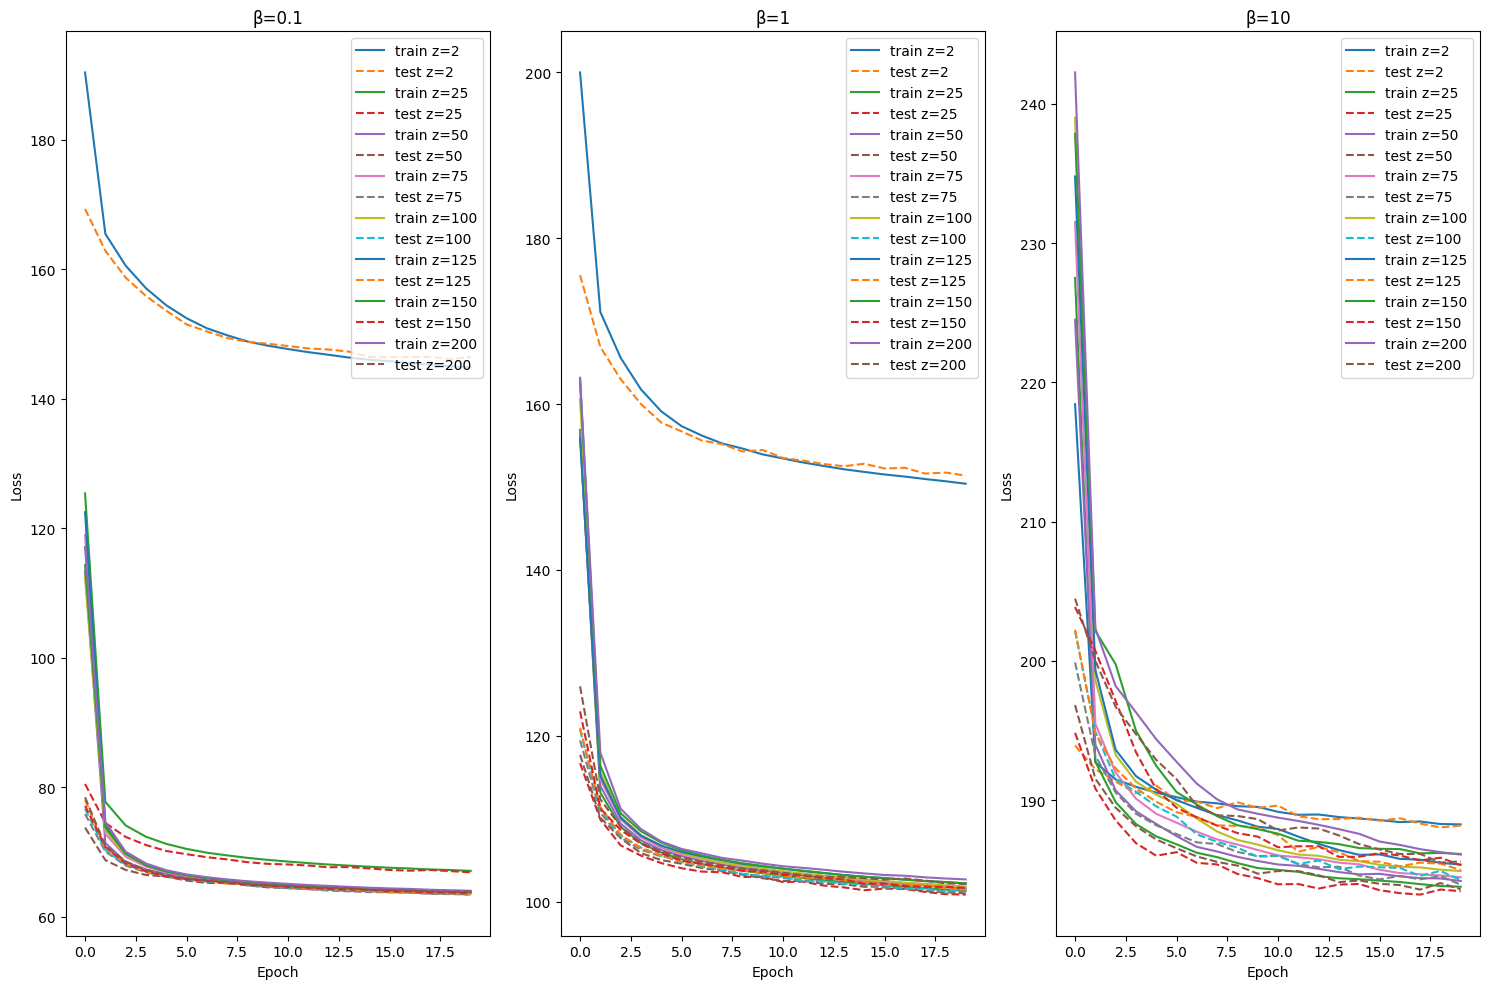

In [ ]:


plt.figure(figsize=(15,10))

for beta in betas:
    plt.subplot(1, len(betas), betas.index(beta)+1)
    for latent_dim in latent_dims:
        plt.plot(results[(latent_dim,beta)]['train_losses'], label=f"train z={latent_dim}")
        plt.plot(results[(latent_dim,beta)]['test_losses'], linestyle='--', label=f"test z={latent_dim}")
    plt.title(f"β={beta}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

plt.tight_layout()

#  Save the figure
plt.savefig("vae_loss_curves.png", dpi=300)

#  Optionally show it too
plt.show()


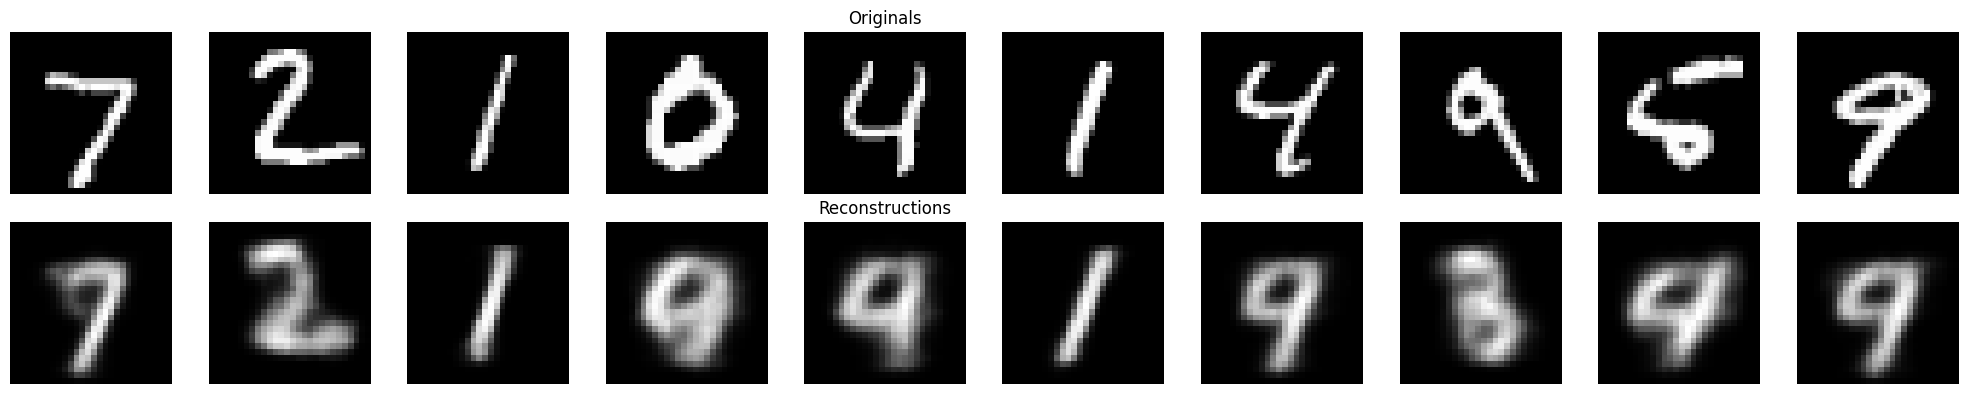

In [ ]:


model.eval()

# Take 10 test images
test_iter = iter(test_loader)
images, _ = next(test_iter)
images = images[:10].to(device)

# Get reconstructions
with torch.no_grad():
    recon_images, mu, logvar = model(images)

# Move to CPU & numpy
images = images.cpu().numpy()
recon_images = recon_images.cpu().numpy()

# Plot originals & reconstructions
plt.figure(figsize=(20, 4))
for i in range(10):
    # Original
    plt.subplot(2, 10, i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.axis('off')
    if i == 4:
        plt.title("Originals", fontsize=12)

    # Reconstruction
    plt.subplot(2, 10, i+11)
    plt.imshow(recon_images[i][0], cmap='gray')
    plt.axis('off')
    if i == 4:
        plt.title("Reconstructions", fontsize=12)

plt.tight_layout()
plt.savefig("vae_test_reconstructions.png", dpi=300)
plt.show()


In [ ]:
print(model)


CNN_VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=3136, out_features=200, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=200, bias=True)
  (decoder_input): Linear(in_features=200, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)
